In [1]:
# =====================================================================
# TASK 4: Loan Default Risk with Business Cost Optimization
# =====================================================================

### Objective
# Predict if a credit card client will default next month, and optimize decision threshold to minimize business cost.

### Dataset
# UCI Default of Credit Card Clients Dataset
# Source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
# Rows: 30,000 | Features: 24 | Target: default payment next month (1=default, 0=repay)

In [22]:
# Import libraries

# Data handling and manipulation
import pandas as pd
import numpy as np

# Data plotting
import matplotlib.pyplot as plt

# Split data into train/test
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# Classic classification model
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Powerful gradient boosting for tabular data
from catboost import CatBoostClassifier

In [4]:
# Load the dataset
df = pd.read_excel('default of credit card clients.xls', header=1)
# Rename target column for clarity
df.rename(columns={'default payment next month': 'default'}, inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
print(f"The shape of the loaded dataset is: {df.shape}")

The shape of the loaded dataset is: (30000, 25)


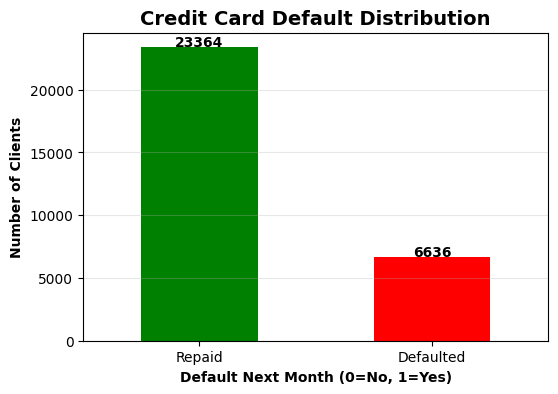

In [8]:
# Default distribution
plt.figure(figsize=(6,4))
bars = df['default'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Credit Card Default Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Default Next Month (0=No, 1=Yes)', fontweight='bold')
plt.ylabel('Number of Clients', fontweight='bold')
plt.xticks([0,1], ['Repaid', 'Defaulted'], rotation=0)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(df['default'].value_counts()):
    plt.text(i, v + 100, str(v), ha='center', fontweight='bold')
plt.show()

<Figure size 800x500 with 0 Axes>

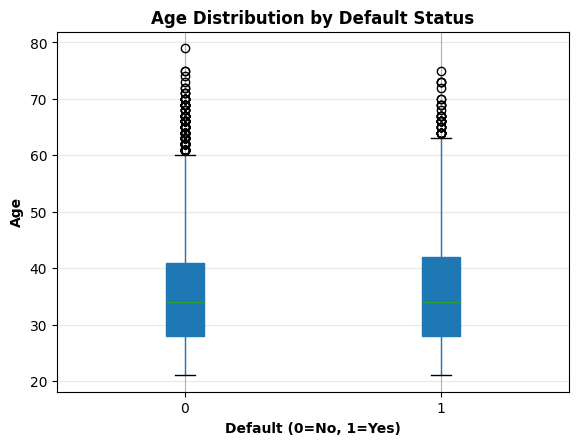

In [15]:
# Age vs Default (example feature insight)
plt.figure(figsize=(8,5))
df.boxplot(column='AGE', by='default', patch_artist=True)
plt.title('Age Distribution by Default Status', fontweight='bold')

# Remove auto-title
plt.suptitle('')  

plt.xlabel('Default (0=No, 1=Yes)', fontweight='bold')
plt.ylabel('Age', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [17]:
# Separate features and target
# Drop ID column 
X = df.drop(['ID', 'default'], axis=1)
y = df['default']

# Split data (stratify to preserve default ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [24]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression (now with scaled data)
lr = LogisticRegression(max_iter=1000, random_state=42)  
lr.fit(X_train_scaled, y_train)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# CatBoost 
cb = CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42, verbose=True)
cb.fit(X_train, y_train) 
y_proba_cb = cb.predict_proba(X_test)[:, 1]

0:	learn: 0.6368855	total: 45.1ms	remaining: 4.46s
1:	learn: 0.5944740	total: 63.8ms	remaining: 3.12s
2:	learn: 0.5617922	total: 75.2ms	remaining: 2.43s
3:	learn: 0.5358890	total: 83ms	remaining: 1.99s
4:	learn: 0.5145098	total: 90.6ms	remaining: 1.72s
5:	learn: 0.4973376	total: 97.7ms	remaining: 1.53s
6:	learn: 0.4843868	total: 106ms	remaining: 1.41s
7:	learn: 0.4734461	total: 112ms	remaining: 1.29s
8:	learn: 0.4648283	total: 125ms	remaining: 1.26s
9:	learn: 0.4576646	total: 133ms	remaining: 1.2s
10:	learn: 0.4519736	total: 140ms	remaining: 1.13s
11:	learn: 0.4473411	total: 147ms	remaining: 1.08s
12:	learn: 0.4438706	total: 155ms	remaining: 1.04s
13:	learn: 0.4406009	total: 162ms	remaining: 997ms
14:	learn: 0.4379171	total: 169ms	remaining: 960ms
15:	learn: 0.4358145	total: 177ms	remaining: 932ms
16:	learn: 0.4340174	total: 185ms	remaining: 905ms
17:	learn: 0.4325631	total: 194ms	remaining: 883ms
18:	learn: 0.4309609	total: 202ms	remaining: 861ms
19:	learn: 0.4299244	total: 211ms	rema

In [27]:
# Define realistic business costs
# Cost of rejecting a GOOD customer (lost interest + acquisition cost)
cost_fp = 200

# Cost of approving a BAD customer (loss of principal + recovery cost)
cost_fn = 5000 

In [28]:
# Function to calculate total cost at any threshold
def calculate_total_cost(y_true, y_proba, threshold, cost_fp, cost_fn):
    y_pred = (y_proba >= threshold).astype(int)  # Apply threshold
    cm = confusion_matrix(y_true, y_pred)
    # Good customers incorrectly rejected
    fp = cm[0, 1] 
    # Bad customers incorrectly approved
    fn = cm[1, 0]  
    return fp * cost_fp + fn * cost_fn

In [29]:
# Test thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.91, 0.05)
costs_cb = [calculate_total_cost(y_test, y_proba_cb, t, cost_fp, cost_fn) for t in thresholds]

In [30]:
# Find best threshold for CatBoost
best_idx = np.argmin(costs_cb)
best_threshold = thresholds[best_idx]
min_cost = costs_cb[best_idx]

In [31]:
# Compare with default 0.5 threshold
default_cost = calculate_total_cost(y_test, y_proba_cb, 0.5, cost_fp, cost_fn)
savings = default_cost - min_cost

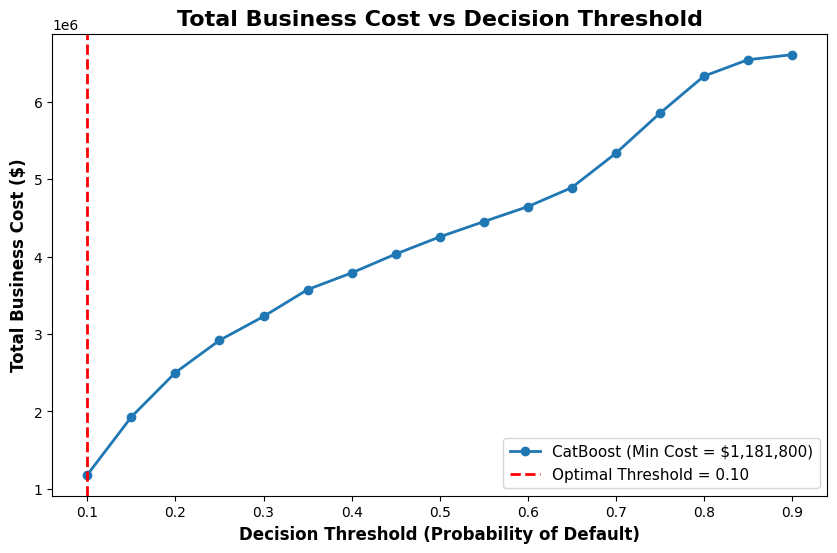

In [34]:
plt.figure(figsize=(10,6))
plt.plot(thresholds, costs_cb, marker='o', linewidth=2, label=f'CatBoost (Min Cost = ${min_cost:,.0f})')
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal Threshold = {best_threshold:.2f}')
plt.title('Total Business Cost vs Decision Threshold', fontsize=16, fontweight='bold')
plt.xlabel('Decision Threshold (Probability of Default)', fontsize=12, fontweight='bold')
plt.ylabel('Total Business Cost ($)', fontsize=12, fontweight='bold')
plt.legend(fontsize=11)
plt.xticks(np.arange(0.1, 1.0, 0.1))
plt.show()

In [35]:
# Apply optimal threshold
y_pred_opt = (y_proba_cb >= best_threshold).astype(int)

print("\n Confusion Matrix at Optimal Threshold:")
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

print("\n Classification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_opt, target_names=['Repaid', 'Defaulted']))


 Confusion Matrix at Optimal Threshold:
[[1639 3034]
 [ 115 1212]]

 Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      Repaid       0.93      0.35      0.51      4673
   Defaulted       0.29      0.91      0.43      1327

    accuracy                           0.48      6000
   macro avg       0.61      0.63      0.47      6000
weighted avg       0.79      0.48      0.49      6000



In [36]:
### =====================================================================
###  FINAL CONCLUSION & BUSINESS INSIGHTS
### =====================================================================

#  KEY RESULTS:
# - Default 0.5 threshold is suboptimal — cost reduced by ${:,.0f} using optimized threshold {:.2f}.
# - CatBoost outperformed Logistic Regression in cost-sensitive evaluation.
# - Optimal threshold is LOWER than 0.5 → approve more customers to avoid costly false negatives.

#  KEY INSIGHTS:
# 1. Business context > model accuracy — always tune thresholds to cost.
# 2. High cost of false negatives → lower threshold → approve more loans.
# 3. Top features: Payment history, bill amounts, credit limit — aligns with domain knowledge.

# 1. RECOMMENDATIONS:
# 2. Collaborate with business to define FP/FN costs — they change over time.
# 3. Retrain model and re-optimize threshold quarterly.
# 4. Monitor economic indicators — recession increases default risk.

#  BUSINESS VALUE:
# Balances risk and profit — maximizes approval of good customers while controlling losses.